# Gradient Descent 

In [1]:
import logging 
import numpy as np 
import pandas as pd

import algo_ecg.data
import algo_ecg.preprocessing
from algo_ecg.feature_transformer import calculate_hrv_based_on_peak_intervals, FindPeaksCustomTransformer, select_cols

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler



Tutorial link: https://atmamani.github.io/projects/ml/implementing-logistic-regression-in-python/

In [2]:
def sigmoid(z):
    denom = 1+np.e**(0-z)
    return 1/denom

In [3]:
def cost_function(theta, X, y):
    m=np.size(y)  # number of training samples
    
    h_theta_x = sigmoid(np.dot(X,theta))
    term1 = (0-y)*np.log(h_theta_x)
    term2 = (1-y)*np.log(1-h_theta_x)
    J = (np.sum(term1-term2))/m
    
    grad = np.dot(np.transpose(h_theta_x - y),X)
    grad = grad/m
    
    return (J, grad)

In [117]:
def gradient_descent(X, y, theta,
                    alpha=0.01, num_iterations=1500):
    """
    Solve for theta using Gradient Descent optimiztion technique. 
    Alpha is the learning rate
    """
    m = len(y)
    J_history = []
    theta0_history = []
    theta1_history = []
    theta2_history = []
    theta = theta.reshape(3,1)

    for i in range(num_iterations):
        error = (np.dot(X, theta) - y)
        
        term0 = (alpha/m) * np.sum(error* X[:,0].reshape(m,1))
        term1 = (alpha/m) * np.sum(error* X[:,1].reshape(m,1))
        term2 = (alpha/m) * np.sum(error* X[:,2].reshape(m,1))
        
        # update theta
        term_vector = np.array([[term0],[term1], [term2]])
#         print(term_vector)
        theta = theta - term_vector.reshape(3,1)
        
        # store history values
        theta0_history.append(theta[0].tolist()[0])
        theta1_history.append(theta[1].tolist()[0])
        theta2_history.append(theta[2].tolist()[0])
        J_history.append(cost_function(theta,X,y)[0])

    return (theta, J_history, theta0_history, theta1_history, theta2_history)

# Load data and run

In [73]:
X_in, y = algo_ecg.data.import_physionet_data('../data', num_files_to_read=1000)
X = algo_ecg.preprocessing.preprocess(X_in)
slice_length = len(X[0])
X = np.concatenate(X).reshape(-1, slice_length, 1)
X = pd.DataFrame.from_records(X)

In [115]:
pipe = Pipeline(steps=[
    ('peaks', FindPeaksCustomTransformer (axis=1)), 
    ('feature_select_manual',FunctionTransformer(select_cols, kw_args={"col_names": ['avg_nni','rmssd']})),
    ('standardscaler', StandardScaler())
])


In [75]:
X_df = pipe.fit_transform(X)

In [76]:
X_df2 = pd.DataFrame.from_records(X_df)

In [77]:
X_df2.head(2)

,0,1
0,-0.669734,-0.348685
1,0.408232,1.116316


In [78]:
x_0 = np.ones(X_df.shape[0]).reshape(X_df.shape[0],1)
#x_0

In [79]:
X2 = np.concatenate((x_0, X_df), axis=1)
X2.shape

(690, 3)

In [80]:
X_df.shape

(690, 2)

In [81]:
initial_theta = np.zeros(X_df.shape[1]+1).reshape(X_df.shape[1]+1,1)
initial_theta.reshape(3,1)

array([[0.],
       [0.],
       [0.]])

In [82]:
initial_theta2 = (np.ones(3)-0.5).reshape(3,1)
initial_theta2.reshape(3,1)

array([[0.5],
       [0.5],
       [0.5]])

In [83]:
# compute cost and gradient
(J, grad) = cost_function(initial_theta, X2, y)
print(f'Cost at initial theta: {J}')
print(f'Gradient at inital theta: {grad.flatten()}')

Cost at initial theta: 478.271554586362
Gradient at inital theta: [5.00000000e-01 2.57443020e-18 8.75306269e-17 ... 5.00000000e-01
 2.57443020e-18 8.49561967e-17]


In [118]:
%%time
num_iterations=150
alpha=0.0002
theta, J_history, theta0_history, \
theta1_history, theta2_history = gradient_descent(X2,y,initial_theta2,
                                                  alpha,num_iterations)

CPU times: user 1.09 s, sys: 2.81 s, total: 3.9 s
Wall time: 474 ms


In [119]:
theta

array([[1.37681159e-01],
       [1.99828419e-11],
       [1.99828418e-11]])

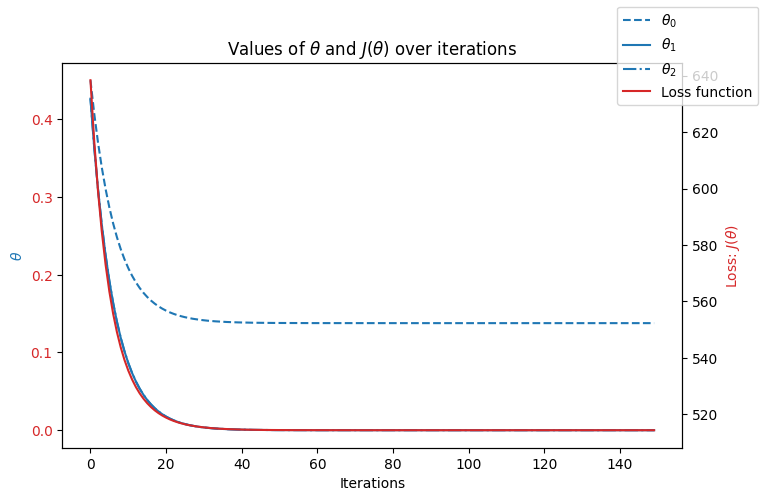

In [120]:
fig, ax1 = plt.subplots(figsize=(8,5))

# plot thetas over time
color='tab:blue'
ax1.plot(theta0_history, label='$\\theta_{0}$', linestyle='--', color=color)
ax1.plot(theta1_history, label='$\\theta_{1}$', linestyle='-', color=color)
ax1.plot(theta2_history, label='$\\theta_{2}$', linestyle='-.', color=color)
# ax1.legend()
ax1.set_xlabel('Iterations'); ax1.set_ylabel('$\\theta$', color=color);
ax1.tick_params(axis='y', labelcolor=color)

# plot loss function over time
color='tab:red'
ax2 = ax1.twinx()
ax2.plot(J_history, label='Loss function', color=color)
ax2.set_title('Values of $\\theta$ and $J(\\theta)$ over iterations')
ax2.set_ylabel('Loss: $J(\\theta)$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# ax2.legend();
fig.legend();